In [95]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Simulate particles translating through OAM beam 

Liz Strong 4/17/2020

In [1]:
import sys
sys.path.append('../slvel')

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from calc_intensity import calculate_e_field_intensity
from scattering_particle import Particle
import scattering_sim as scatsim
import random

### make pretty plots

In [97]:
%matplotlib notebook

### calculate intensity

In [98]:
xval = 986 # grid x size [pixels]
yval = 616 # grid y size [pixels]
l = 4 # OAM azimuthal mode number
w0 = 93.8458 # beam waist [pixels]
intensity, intensity_shape = calculate_e_field_intensity(l=l,
                                                         p=0,
                                                         w0=w0,
                                                         x=xval,
                                                         y=yval,
                                                         petaledbeam=True)

<IPython.core.display.Javascript object>


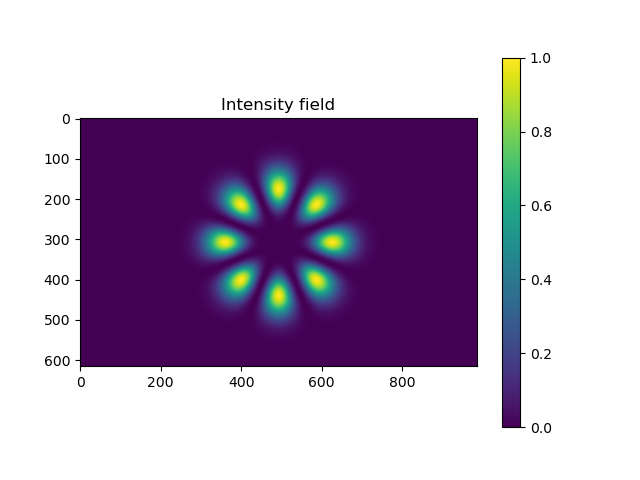

Text(0.5, 1.0, 'Intensity field')

In [99]:
plt.figure()
plt.imshow(intensity)
plt.colorbar()

plt.title('Intensity field')

### make particle to sample the intensity field

In [100]:
r = 20 # particle radius [pixels]
p1 = Particle(intensity_shape,
              particle_radius=r,
              orbit_radius=75,
              orbit_offset_x=75,
              orbit_offset_y=0,
              v=5000,
              sample_rate=100000,
              direction=-1)

### presum intensities particle will experience

This is slow, so calculate the file once and then save it to load the file later. 

In [101]:
#presummed_intensity = p1.calculate_sampled_intensities_throughout(Intensity_normalized)
#np.save('psi_11_24_19_w0_93.8458.npy', presummed_intensity)
psi = np.load('psi_11_24_19_w0_93.8458.npy')

### calculate intensities on particle's orbit

### set parameters for simulation

Total number of simulations: num_theta * num_radii * num_d * num_angvels

In [102]:
offset_x = [355, 425] # x coordinate of D [pixels]
offset_y = [0,0] # y coordinate of D [pixels]
orbit_radius = {} # orbit radius [pixels]
D = [np.sqrt(x**2+y**2) for x,y in zip(offset_x, offset_y)] # D [pixels]
radius = [490, 325] # orbit radius [pixels]
for dist, rad in zip(D, radius): 
    orbit_radius[dist] = [rad]
orbit_radius = [490, 325]
angle = np.arctan2(offset_y, offset_x) # phi [rad]
angular_velocities = [250, 250] # Omega [rad/s]

### Make time series.

In [122]:
data = scatsim.simulate_time_series(p1, 
                                    psi, 
                                    intensity_shape, 
                                    offset_x, 
                                    offset_y, 
                                    D, 
                                    angle, 
                                    angular_velocities, 
                                    orbit_radius, 
                                    xval, 
                                    yval)

time_keep = data[0]
intensities_keep = data[1]
positions_keep = data[2]
angular_velocities_keep = data[3]
R_keep = data[4] 
d_keep = data[5]
offset_x_keep = data[6]
offset_y_keep = data[7]
theta_keep = data[8]

### plot results

<IPython.core.display.Javascript object>


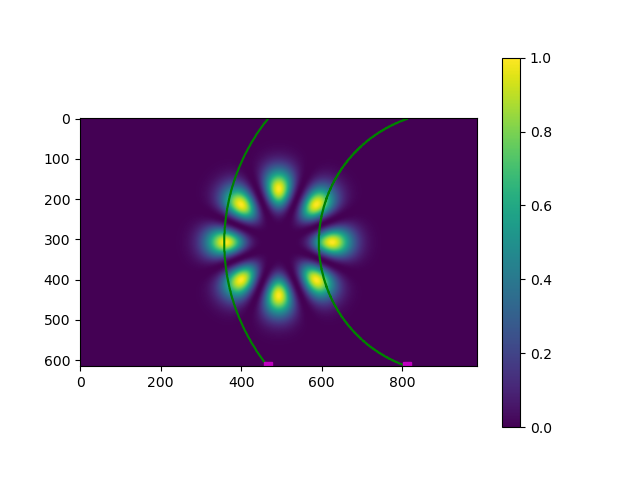

<IPython.core.display.Javascript object>


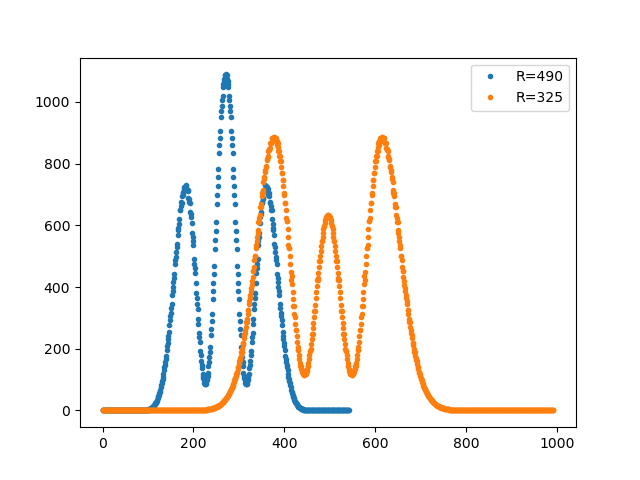

In [123]:
plt.figure()
plt.imshow(intensity)

for selxn in range(2):
    plt.plot(positions_keep[selxn].T[0],positions_keep[selxn].T[1],'g')
    plt.plot(positions_keep[selxn].T[0][0],positions_keep[selxn].T[1][0],'ms')
plt.colorbar()

plt.figure()
for selxn in range(2):
    plt.plot(intensities_keep[selxn],'.',label='R='+str(orbit_radius[selxn]))
plt.legend()


### add noise & concatenate into a long time series

<IPython.core.display.Javascript object>


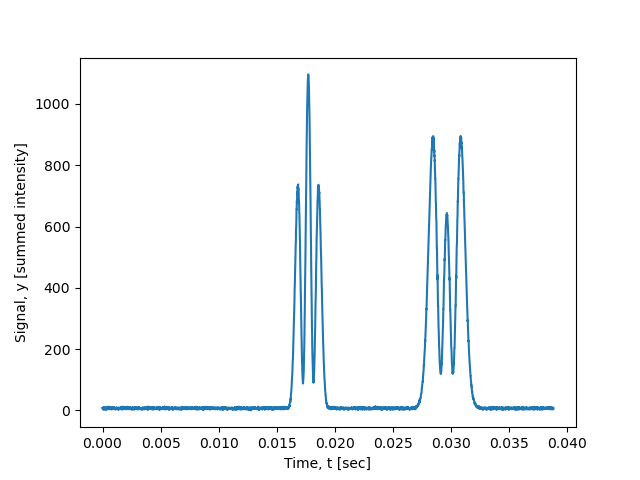

Text(0, 0.5, 'Signal, y [summed intensity]')

In [124]:
timeseries_time, timeseries_intensity, intensities_extended = scatsim.concat_timeseries(intensities_keep, 
                                                                                      time_keep, 
                                                                                      ext_length=420)
plt.figure()
plt.plot(timeseries_time, timeseries_intensity)
plt.xlabel('Time, t [sec]')
plt.ylabel('Signal, y [summed intensity]')

### Save angular velocities with times to correlate them later for ML training purposes

In [125]:
# save angular velocities corresponding to each seg
vs = scatsim.save_series_info(angular_velocities_keep, intensities_keep, intensities_extended)

# save orbit radii corresponding to each seg 
Rs = scatsim.save_series_info(R_keep, intensities_keep, intensities_extended)

# save x offset radii corresponding to each seg 
delta_xs = scatsim.save_series_info(offset_x_keep, intensities_keep, intensities_extended)

# save y offset radii corresponding to each seg 
delta_ys = scatsim.save_series_info(offset_y_keep, intensities_keep, intensities_extended)


### save data

In [126]:
data_to_save = np.array([timeseries_time,timeseries_intensity,angular_velocities_keep,vs,Rs,delta_xs,delta_ys])
np.save('example_simulated_signal.npy',data_to_save)